In [21]:
import tensorflow as tf
import numpy as np
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt

In [53]:
class Cutout:
    """Progressive Sprinkles Agumentation.

    Args:
        num_holes: number of holes to make in an image
        side_length: lenght of sides each hole will have.

    Returns:
        Image with number of holes of specified size cut out.
    """

    def __init__(self, num_holes, side_length):
        self.n = num_holes
        self.length = side_length

    def __call__(self, image):
        tf.cast(image, tf.float32)
        img_shape = tf.shape(image)
        i = tf.range(img_shape[0])
        j = tf.range(img_shape[1])
        masking_fn = Cutout._mask_out(image, img_shape, i, j, self.length)
        idx = tf.constant(0, dtype=tf.int32)
        image, idx = tf.while_loop(
            cond=lambda x, ii: tf.less(ii, self.n),
            body=masking_fn,
            loop_vars=[image, idx]
        )
        return image

    @staticmethod
    def _mask_out(image, img_shape, row_range, col_range, hole_length):
        """Masks rows and columns to be replaced."""
        shape = tf.shape(image)
        rows = shape[0]
        cols = shape[1]
        channels = shape[2]

        def _create_hole(image, idx):
            # Do the masking.
            r = tf.random_uniform([], minval=0, maxval=rows, dtype=tf.int32)
            c = tf.random_uniform([], minval=0, maxval=cols, dtype=tf.int32)

            r1 = tf.clip_by_value(r - hole_length // 2, 0, rows)
            r2 = tf.clip_by_value(r + hole_length // 2, 0, rows)
            c1 = tf.clip_by_value(c - hole_length // 2, 0, cols)
            c2 = tf.clip_by_value(c + hole_length // 2, 0, cols)

            row_mask = (r1 <= row_range) & (row_range < r2)
            col_mask = (c1 <= col_range) & (col_range < c2)
            zeros = tf.zeros(shape)

            # Full mask of replaced elements
            mask = row_mask[:, tf.newaxis] & col_mask

            # Select elements from flattened arrays
            img_flat = tf.reshape(image, [-1, channels])
            zeros_flat = tf.reshape(zeros, [-1, channels])
            mask_flat = tf.reshape(mask, [-1])
            result_flat = tf.where(mask_flat, zeros_flat, img_flat)

            # Reshape back
            result = tf.reshape(result_flat, img_shape)
            return [result, idx + 1]
        return _create_hole

In [176]:
class Cutout2:
    """Progressive Sprinkles Agumentation.

    Args:
        num_holes: number of holes to make in an image
        side_length: lenght of sides each hole will have.

    Returns:
        Image with number of holes of specified size cut out.
    """

    def __init__(self, num_holes, side_length):
        self.n = num_holes
        self.length = side_length

    def __call__(self, image):
        tf.cast(image, tf.float32)
        img_shape = tf.shape(image)
        print(img_shape.eval())
        rows = img_shape[0]
        cols = img_shape[1]
        num_channels = img_shape[-1]
        mask = tf.ones([rows, cols], dtype=tf.int64)
        r_idx = tf.random_uniform([self.n], minval=0, maxval=rows-1, dtype=tf.int32)
        c_idx = tf.random_uniform([self.n], minval=0, maxval=cols-1, dtype=tf.int32)
        indices = tf.cast(tf.stack([r_idx, c_idx], axis=1), tf.int64)
        indices = tf.sort(indices, axis=1)
        indices = tf.sort(indices, axis=0)
        sparse_mask = tf.SparseTensor(indices, tf.ones([self.n], dtype=tf.int64),
                                      [rows, cols])
        dense_mask = tf.sparse_tensor_to_dense(sparse_mask)
        mask = tf.cast(mask - dense_mask, tf.bool)
        filtered_image = tf.boolean_mask(tf.reshape(image, (-1, num_channels)),
                                         tf.reshape(mask, (-1,)),
                                         axis=0)
        return tf.reshape(filtered_image, (rows, cols, -1))

In [8]:
data_path = Path.cwd() / 'data' / 'cat.jpeg'

In [9]:
data_path

WindowsPath('C:/Users/ntoner/Documents/Programming/tf_sprinkles/data/cat.jpeg')

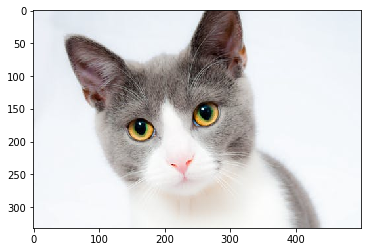

In [13]:
plt.imshow(Image.open(data_path.as_posix()))

In [17]:
img = Image.open(data_path.as_posix())

In [25]:
img = np.asarray(img) / 255.

In [26]:
img.shape

(332, 500, 3)

In [43]:
img.dtype

dtype('float64')

In [87]:
sprinkle = Cutout(100, 10)

679 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


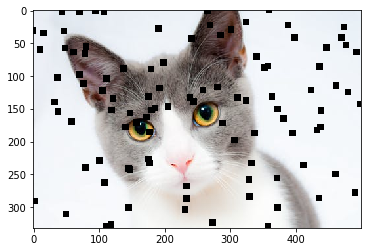

In [59]:
%%timeit
with tf.Session() as sess:
    result = sprinkle(tf.constant(img, dtype=tf.float32))
    plt.imshow(result.eval())

In [179]:
sprinkle2 = Cutout2(10, 10)

In [180]:
# %%timeit
with tf.Session() as sess:
    result = sprinkle2(tf.constant(img, dtype=tf.float32))
    plt.imshow(result.eval())

[332 500   3]


InvalidArgumentError: Input to reshape is a tensor with 497970 values, but the requested shape requires a multiple of 166000
	 [[node Reshape_23 (defined at <ipython-input-176-c52a35263094>:36) ]]

Errors may have originated from an input operation.
Input Source operations connected to node Reshape_23:
 boolean_mask_14/GatherV2 (defined at <ipython-input-176-c52a35263094>:35)

Original stack trace for 'Reshape_23':
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\ipykernel\kernelapp.py", line 563, in start
    self.io_loop.start()
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-180-4b84e98e5009>", line 3, in <module>
    result = sprinkle2(tf.constant(img, dtype=tf.float32))
  File "<ipython-input-176-c52a35263094>", line 36, in __call__
    return tf.reshape(filtered_image, (rows, cols, -1))
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 9093, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\ntoner\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()
